# Zomato Recommendation Engine

Make a restaurant recommendation engine for Zomato using user review data.

![alt text](zomato-banner.png)

## Prologue

You have been lucky and after graduation got employed as a Data Engineer at Zomato. You have been living in Mumbai, spending your big fat check, but due to the recent emergence of Swiggy, Zomato is now facing a major competitor in the market. Your boss Dr Mukherjee, given the situation, has assigned you to improve the recommendation engine employed at Zomato. It is now upon you to keep your stocks floating and grab that year-end bonus.

It has been two days since you were assigned the project, you researched about recommender systems, for which you found [this blog](https://towardsdatascience.com/brief-on-recommender-systems-b86a1068a4dd) extremely helpful. After reading the blog, you decided to make a **collaborative filtering based recommendation system using autoencoders**, since Zomato was already using content-based filtering which wasn't giving promising results. You decided to use user review data on restaurants situated in Mumbai since it has a high user engagement. Following are the notes, you made while researching:

<!-- In this assignment, we will be working on implementing a recommendation system on Zomato's user reviews data for different restaurants. We will be using a technique called Collaborative Filtering which is one of the most popular ways of implementing a recommendation system and we will be training an autoencoder. Don't be afraid if you have never heard these terms before we will be explaining them in detail. -->

## Collaborative Filtering

Let's say we have ratings of 5 users on 4 different restaurants and a user might not have rated a particular restaurant. We can create arrange the ratings in a user-restaurant matrix from the data, that looks like this:

![alt text](data.png)

As you can see the users have not rated all the restaurants. In collaborative filtering we try to find these missing values and based on these values we make a recommendation to them. In this figure, for example, Kabir has rated ANC and Looters but not Food King, however Suvigya has rated all three of these restaurants. We can observe that the ratings of Suvigya on ANC and Looters match a lot with Kabir and we can to some extent say that Kabir's rating for Food King will be close to 2. 

## Autoencoders

**Youtube Video:** https://www.youtube.com/watch?v=9zKuYvjFFS8 (till 5:36)

An autoencoder is a neural network which learns to copy its input to its output. The network can be viewed as consisting 2 parts, an encoder which downsamples the input to a compact representation and a decoder which produces a reconstruction of the input. Autoencoders falls under the area of unsupervised learning algorithms, since for training an autoencoder we only need raw data without any label. An autoencoder with one hidden layer is shown below:


![alt text](autoencoder.png) 

Please note that we can have as many layers as we want in our autoencoder. The only thing to keep in mind is to reduce the dimensionality of the input in the encoder part of the network and increase the dimensionality of the hidden representation to the size of actual input in decoder network.

Once we have defined the architecture of our autoencoder, we can train it using the following steps:

1.   Feed the batch of inputs *x* to the network and obtain the predictions *p*
2.   Compute the loss between the reconstructed inputs *p* and the actual inputs *x* i.e. *L(p,x)*
3. Compute the gradients of this loss with respect to the parameters of the model using backprop.
4. Use these gradients to take optimization step, for e.g. Stochastic Gradient Descent.
5. Repeat steps 1-4 till convergence.

## Collaborative Filtering using Autoencoders

We will now see how to use autoencoders for collaborative filtering. Lets first see the steps involved in training an autoencoder for this problem and then we will develope an intuition on why it works.

![alt text](autoencoder2.png)

In the figure we are feeding Kabir's ratings to the autoencoder. Note that the ratings corresponding to the missing values are kept zero. After computing the predictions of autoencoder we compute mean squared error between the input ratings and the ratings predicting by the network. One important thing to note here is that while computing the loss we do not consider the predictions corresponding to 0 ratings i.e. the missing values and only compute the error for the ratings that we are given. This is because we do not want our network to learn that the output corresponding to the missing values is zero but instead learn a reasonable value. We repeat the same thing for other users and then backprogate the gradients and take optimization steps.

During test time we will feed the input with the missing ratings to the network and use the output of the network to determine the ratings of the missing values. Once we have the ratings for those missing values we can make a recommendation accordingly.

![alt text](autoencoder3.png)


After reading your notes, you decided to proceed with building the recommendation engine.

Fortunately, you don't have to worry about the data collection as your team member Suvigya has already collected the data from Zomato's website in the required format using the code [here](https://github.com/suvigyavijay/zomato-scraper).

![alt text](restaurants_data.png)

![alt text](review_data.png)

After the data collection, another team member, Kabir helped out and extracted the ratings and preprocessed it. Finally, he provided you with the train-test split, in order to ensure that you spent more time on designing the algorithm instead of engineering the data. 

In [1]:
#Loading necessary packages and defining global variables
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from collections import defaultdict
import os
from torch.utils import data
import matplotlib.pyplot as plt
import pandas as pd
from sys import platform

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cpu")
OUTPUT_DIR_TRAIN='data/train.dat'
OUTPUT_DIR_TEST='data/test1.dat'

NUM_RESTS = 5138
NUM_USERS = 3579

## Restaurant reviews data

We have reviews of 5138 restaurants from 3579 different users. Each user is given an ID from 0 to 3578 and similarly, each restaurant is given an ID from 0 to 5137. We have provided you 3 files `train.dat` and `test1.dat` and `test_hidden.dat` containing training data, testing data and hidden test data respectively. For now, do not worry about `train_hidden.dat`. The format of data in the other 2 files is:

                        userID, restaurantID, rating
                        
This means each row contains a rating given to a particular restaurant by a given user. Please have a look at the files and ensure what we said makes sense. The figure below shows how the split has been made from the original data to training and test set.

![alt text](datasplit.png)

We have removed some ratings from each user at random from train set and added them to test set. This way we can compare the final predictions on the train set and compare with ratings present in the test set, to find out how the network is actually performing.

During training, we use the rating data from the `train.dat` file to train our autoencoder. During testing though we feed the data from `train.dat` to the autoencoder and compare the predictions with the values given in `test.dat`. The figure given below demonstrates the testing process.

![alt text](testing.png)

`test_hidden.dat` only contains the userID and restaurantID and not the ratings. Finally, you will be making predictions for these restaurants, user pairs and will be submitting your predictions to the Kaggle competition. We will then evaluate your predictions against the actual ratings and you will be ranked on the leaderboard accordingly.

## Task 1: Implement get_sparse_mat function (2 marks)

Before we start building our model, we first need to get our data in a suitable form which can be fed to the network. The input to the network will be a vector of size 5138 (number of restaurants) for each user, where each element of the vector will contain the rating of the restaurant whose id matches with the index of that element. If the user has not rated a particular restaurant, the element corresponding to that will be set to zero. 

For example: If a user has only rated the restaurants with ids 3, 19 and 1009 as 2, 4 and 3.5 respectively, then the feature vector for that user will be a 5138 sized array containing 2 in the index 3, 4 in the index 19, 3.5 in index 1009 and zero everywhere else.

Hence our full dataset will be a matrix of size 3579 X 5138 (number of users X number of restaurants).

Since we know that the users have reviewed only a small portion of all 5138 restaurants, the data matrix will be very sparse (will mostly contain zeros). Hence it does not make sense to store the whole 3579 X 5138 matrix in memory. Instead, we create a sparse matrix where for each user we store the tuples containing the restaurant id and the rating for that restaurant. 

For example: In the previous example where we had a user who rated restaurants 3, 19 and 1009 only, we will store the tuples [(3, 2), (19, 4), (1009, 3.5)]. Earlier we store an array of size 5138 elements for the user but now we need to have an array containing 3 elements, saving much memory. While feeding the inputs to the neural net we convert this sparse representation to the full 5138-dimensional vector.

The function `get_sparse_mat` takes as the input the filename string which can either be `train.dat` and `test.dat` and constructs a sparse matrix containing the list of tuples for each user as we described above. The output of the function should be a python list of size 3579 with each element being a list of tuples.

![alt text](get_sparse_mat.png)

**Note 1:** You can read .dat files similar to how you read .txt files. Use python's inbuilt function *open* to create a file pointer lets say *fp*, then you can use functions like read, readline etc. to read the data values from the file. Refer to this [link](https://www.programiz.com/python-programming/file-operation) if you want a refresher to file IO in python.

**Note 2:** You can also read .dat files using pandas similar to the way you read CSV files using *pd.read_csv* function.

**Note 3:** The tuples in the list (restaurantID, rating) should have restaurantID as an integer value and rating as a float.


In [2]:
def get_sparse_mat(filename):
  
    '''
    
    Inputs: 
        -filename: a string containing the name of the file from which we want
                    to extract the data. In our case it can be either train.dat
                    or test.dat
                    
    Returns a python list of size 3579 (number of users) with each element of
    the list being a list of tuples (restaurantID, rating).
    
    '''
    
    sparse_mat = []
    
    # YOUR CODE HERE
    df=pd.read_csv(filename, names=['userID','restID','rating'],header=None)
    df['tuple'] = list(zip(df.restID, df.rating))
    keys, values = df[['userID','tuple']].to_numpy().T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values, index[1:])
    df2 = pd.DataFrame({'a':ukeys, 'b':[list(a) for a in arrays]})
    return df2.b.tolist()

In [3]:
#Now that we have implemented the get_sparse_mat function we can get the train and test sparse matrices
train_smat = get_sparse_mat(OUTPUT_DIR_TRAIN)
test_smat = get_sparse_mat(OUTPUT_DIR_TEST)

In [4]:
                            """Don't change code in this cell"""
#SAMPLE TEST CASE
print("Running Sample Test Case 1")
assert np.allclose(len(train_smat), 3579)
print("Sample Test Case 1 Passed")
print("Running Sample Test Case 2")
assert np.allclose(len(test_smat), 3579)
print("Sample Test Case 2 Passed")
print("Running Sample Test Case 3")
assert np.allclose(len(train_smat[5]), 234)
print("Sample Test Case 3 Passed")
print("Running Sample Test Case 4")
assert np.allclose(train_smat[5][:5],[(626, 4.0), (1177, 4.5), (976, 4.0), (3926, 4.0), (3274, 5.0)])
print("Sample Test Case 4 Passed")
print("Running Sample Test Case 5")
assert np.allclose(len(test_smat[5]),5)
print("Sample Test Case 5 Passed")
print("Running Sample Test Case 6")
assert np.allclose(test_smat[5][:5], [(574, 3.5), (3717, 4.0), (2303, 4.0), (863, 3.5), (1706, 1.0)])
print("Sample Test Case 6 Passed")
print("Running Sample Test Case 7")
assert ((type(train_smat[5][:5][0][0]) is int) and (type(train_smat[5][:5][0][1]) is float))
print("Sample Test Case 7 Passed")
print("Running Sample Test Case 8")
assert ((type(test_smat[5][:5][0][0]) is int) and (type(test_smat[5][:5][0][1]) is float))
print("Sample Test Case 8 Passed")

Running Sample Test Case 1
Sample Test Case 1 Passed
Running Sample Test Case 2
Sample Test Case 2 Passed
Running Sample Test Case 3
Sample Test Case 3 Passed
Running Sample Test Case 4
Sample Test Case 4 Passed
Running Sample Test Case 5
Sample Test Case 5 Passed
Running Sample Test Case 6
Sample Test Case 6 Passed
Running Sample Test Case 7
Sample Test Case 7 Passed
Running Sample Test Case 8
Sample Test Case 8 Passed


In [5]:
                            """Don't change code in this cell"""
#HIDDEN TEST CASE


"Don't change code in this cell"

## Dataloaders

Next we have defined a dataset class which can be used to efficiently iterate through the dataset. We have provided its implementation for you. Go through it once and make sure you understand it. Using the dataset objects we define data generators for train and test sets which are used to get batches of input data. To learn about how pytorch's Dataset and Dataloader classes work in detail please go through this link: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [6]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X_sam = torch.zeros(5138)
        y_sam = torch.zeros(5138)
        for i in range(len(self.X[index])):
            X_sam[self.X[index][i][0]] = self.X[index][i][1]

        for i in range(len(self.y[index])):
            y_sam[self.y[index][i][0]] = self.y[index][i][1]

        return X_sam, y_sam

In [7]:
train_dataset = Dataset(train_smat,train_smat)
test_dataset = Dataset(train_smat, test_smat)

In [8]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6 if platform == 'linux' else 0}
training_generator = data.DataLoader(train_dataset, **params)# sampler = torch.utils.data.SequentialSampler(train_dataset))
validation_generator = data.DataLoader(test_dataset, **params)# sampler = torch.utils.data.SequentialSampler(train_dataset))

## Implementing Autoencoder Architecture

Now that we have our datasets ready we can define the architecture of our autoencoder network. We typically define a network architecture in pytorch by extending the nn.Module class. In the cell below we have demonstrated how you can implement a 3 layer neural network with the following architecture in pytorch.

INPUT(size = 100) -> FC+ReLU(size = 64) -> FC+ReLU(size = 32) -> FC(size = 10)

In [9]:
class threeLayerNet(nn.Module):
    
    def __init__(self):
        '''
        In constructor we define different layers we will use in our architecture.
        '''
        #Constructor call to the superclass
        super(threeLayerNet, self).__init__()
        #Defining the layers to be used in the network. 
        #nn.Linear defines a fully connected layer and the first argument represents the input size and the second represents the output size.
        self.layer1 = nn.Linear(100, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 10)
        #Defining the activation function to be used in the network
        self.act = nn.ReLU()
        
    def forward(self, x):
        
        '''
        The forward function takes passes the input through the layers and returns the output.
        Inputs:
            -x : Input tensor of shape [N_batch, 100]
            
        Returns the output of neural network of shape [N_batch, 10]
        '''
        
        out = self.layer1(x)
        out = self.act(out)
        out = self.layer2(out)
        out = self.act(out)
        out = self.layer3(out)
        
        return out
        

In [10]:
#Once we have defined the network class we can create an instance for it.
net = threeLayerNet()

#To get the output of the network on data just call the network instance and feed the inputs

x = torch.rand(5, 100) #Just a random input
network_prediction = net(x)
network_prediction

tensor([[ 0.0429, -0.1079,  0.2100, -0.0437,  0.0598,  0.0489,  0.2232, -0.1854,
         -0.1493, -0.0353],
        [ 0.0209, -0.1134,  0.1992, -0.0460,  0.0336,  0.0557,  0.2156, -0.1789,
         -0.1579, -0.0424],
        [-0.0055, -0.0234,  0.2274, -0.0016,  0.0654,  0.1145,  0.1840, -0.1787,
         -0.1968, -0.0328],
        [-0.0006, -0.0704,  0.2185, -0.0284,  0.0471,  0.0895,  0.2083, -0.1359,
         -0.1475, -0.0158],
        [ 0.0019, -0.0558,  0.2171, -0.0243,  0.0607,  0.1144,  0.2093, -0.1387,
         -0.1523, -0.0283]], grad_fn=<AddmmBackward>)

## Task 2.1 Warmup Excercise: Implement a toy neural network. (1 Mark)

Before you implement the autoencoder architecture as a practice implement a simple 2 layer neural with the following architecture:

INPUT(size = 224) -> FC+ReLU(size = 128) -> FC+tanh(size = 5)

In [11]:
class twolayerNet(nn.Module):
    
    def __init__(self):
        '''
        Define the layers and activation functions to be used in the network.
        '''
        super(twolayerNet, self).__init__()
        
        # YOUR CODE HERE
        self.layer1=nn.Linear(224,128)
        self.layer2=nn.Linear(128,5)
        self.relu=nn.ReLU()
        self.tanh=nn.Tanh()
        #raise NotImplementedError()
        
    def forward(self, x):
        
        '''
        Implement the forward function which takes as input the tensor x and feeds it to the layers of the network
        and returns the output.
        
        Inputs:
            -x : Input tensor of shape [N_batch, 224]
            
        Returns the output of neural network of shape [N_batch, 5]
        '''
        
        out = torch.zeros(x.shape[0], 5)
        # YOUR CODE HERE
        outtemp=self.layer1(x)
        outtemp=self.relu(outtemp)
        outtemp=self.layer2(outtemp)
        out=self.tanh(outtemp)
        #raise NotImplementedError()
        
        return out

In [12]:
net = twolayerNet()

In [13]:
                            """Don't change code in this cell"""
    
### SAMPLE TEST CASE
params_shapes = [p.shape for p in net.parameters()]
params_shapes = sorted(params_shapes)
print("Running Sample Test Case")
assert params_shapes ==[torch.Size([5]),
 torch.Size([5, 128]),
 torch.Size([128]),
 torch.Size([128, 224])]
print("Sample Test Case Passed")

Running Sample Test Case
Sample Test Case Passed


In [14]:
                            """Don't change code in this cell"""
    
### HIDDEN TEST CASE


"Don't change code in this cell"

## Task 2.2: Implement the deep autoencoder (2.5 Marks)

Now you will implement the autoencoder network which we will be using to build our recommendation system. The architeture of the network should be:

INPUT(size = 5138) -> FC+Tanh(size = 32) -> FC(size = 5138);

In [15]:
class DAE(nn.Module):
    def __init__(self):
        '''
        Define the layers and activation functions to be used in the network.
        '''
        super(DAE,self).__init__()
        
        # YOUR CODE HERE
        self.layer1=nn.Linear(5138,32)
        self.layer2=nn.Linear(32,5138)
        self.tanh=nn.Tanh()
        #raise NotImplementedError()
        
    def forward(self, x):
        '''
        Implement the forward function which takes as input the tensor x and feeds it to the layers of the network
        and returns the output.
        
        Inputs:
            -x : Input tensor of shape [N_batch, 5138]
            
        Returns the output of neural network of shape [N_batch, 5138]
        '''
        
        out = torch.zeros(x.shape[0], 5138)
        
        # YOUR CODE HERE
        outtemp=self.layer1(x)
        outtemp=self.tanh(outtemp)
        out=self.layer2(outtemp)
        #raise NotImplementedError()
        return out

In [16]:
net = DAE()

In [17]:
                            """Don't change code in this cell"""
    
### SAMPLE TEST CASE
params_shapes = [p.shape for p in net.parameters()]
params_shapes = sorted(params_shapes)
print("Running Sample Test Case")
assert params_shapes == [torch.Size([32]), torch.Size([32, 5138]), torch.Size([5138]), torch.Size([5138, 32])]
print("Sample Test Case Passed")

Running Sample Test Case
Sample Test Case Passed


In [18]:
                            """Don't change code in this cell"""
### HIDDEN TEST CASE


"Don't change code in this cell"

## Task 3: Implement the loss function (2.5 Marks)

Now that we have defined our autoencoder network we need to define a loss function to train our model. We will be using mean squared error as our loss function which can be simply implemented by taking the squared sum of the errors between the model predictions and the labels and dividing it by the number of training examples. However, there is a small catch here. As we described in the beginning, for a user we have to compute this error for the restaurants whose ratings have been given by the user and not for the restaurants with the missing ratings.

![loss.png](loss.png)

Please note that in the figure we are dividing the sum of squared errors with 4 which comes from the total number of ratings that are available in the input data.

The function masked_loss takes as the input predictions and labels and calculates the mean squared error for the available ratings. One way of doing this is to first define a mask which is zero for the ratings not available and one for the available ones. Then we multiply this mask with the model predictions so that it zeros out the predictions of the network which are missing in the input data. Now we can calculate the sum of squared errors between the masked predictions and the input ratings and divide it with the number of available ratings which can be calculated by counting the number of ones in the mask.

![maskedloss1.png](maskedloss1.png)
![maskedloss2.png](maskedloss2.png)
![maskedloss3.png](maskedloss3.png)

Hint: You might find torch.where function useful in creating the mask.

In [19]:
def masked_loss(preds, labels):
    
    '''
    Inputs:
        -preds: Model predictions [N_batch, 5138]
        -labels: User ratings [N_batch, 5138]
        
    Returns the masked loss as described above.
    '''
    
    loss = 0
    
    # YOUR CODE HERE
    masked_pred = torch.where(labels!=0, preds, labels)
    masked_diff = masked_pred - labels
    loss = torch.sum(torch.mul(masked_diff, masked_diff))/np.count_nonzero(labels.data.numpy())
    #raise NotImplementedError()
    
    return loss

In [20]:
                            """Don't change code in this cell"""
    
### SAMPLE TEST CASE
x = torch.zeros(3, 5138)
x[0][100] = 1
x[0][7] = 1
x[0][1009] = 1
x[1][101] = 1
x[1][8] = 1
x[1][1010] = 1
x[1][56] = 1
x[2][102] = 1
x[2][9] = 1
loss = masked_loss(net(x), x).item()
print("Running Sample Test Case")
assert np.allclose(loss, 1.1857765913009644, atol = 1e-4)
print("Sample Test Case Passed")

Running Sample Test Case
Sample Test Case Passed


In [21]:
                            """Don't change code in this cell"""
    
### HIDDEN TEST CASE


"Don't change code in this cell"

## Defining the Optimizer

Now that we have our autoencoder architecture and loss function ready we only need to define an optimizer object before we begin training. We will be using Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.1. Pytorch comes with optim module which contains different optimizers for optimizing neural nets. We can define an instance of an optimizer as:
optim.OptimizerName(net.parameters(), learning_rate), where the first argument corresponds to the list of parameters of the network and the second parameter being the learning rate. We have defined SGD optimizer object in the cell below.

In [22]:
opti = optim.SGD(net.parameters(), lr=0.1)

## Task 4: Training the model (2 marks)

Now we have everything ready to start training our model. Each iteration will consist of 4 important steps:

1. Feeding input data to the network and obtaining model predictions
2. Compute the loss between inputs and labels say *loss*
3. Backpropagate the gradients using *loss.backward()*
4. Take the optimization step using the *step* method of the optimizer instance.

This function will be manually graded since there the training results might vary each time we run the network. Effectively you should see a decrease in both train and validation losses. The final training loss should be around 1.7 and validation loss should be around 2 to 2.2 towards the end.

In [23]:
def train(net, criterion, opti, training_generator, validation_generator, max_epochs = 10):
    
    '''
    Inputs:
        - net: The model instance
        - criterion: Loss function, in our case it is masked_loss function.
        - opti: Optimizer Instance
        - training_generator: For iterating through the training set
        - validation_generator: For iterating through the test set
        - max_epochs: Number of training epochs. One epoch is defined as one complete presentation of the data set.
    
    Outputs:
        - train_losses: a list of size max_epochs containing the average loss for each epoch of training set.
        - val_losses: a list of size max_epochs containing the average loss for each epoch of test set.
        
        Note: We compute the average loss in an epoch by summing the loss at each iteration of that epoch
        and then dividing the sum by the number of iterations in that epoch.
    '''

    train_losses = []
    val_losses = []
    
    for epoch in range(max_epochs):
        running_loss = 0 #Accumulate the loss in each iteration of the epoch in this variable
        cnt = 0 #Increment it each time to find the number iterations in the epoch.
        # Training iterations
        for batch_X, batch_y in training_generator:
            opti.zero_grad() #Clears the gradients of all variables.
            
            # YOUR CODE HERE
            outputs = net(batch_X)
            loss = criterion(outputs,batch_y)
            running_loss = running_loss + loss.item()
            loss.backward()
            opti.step()
            cnt = cnt + 1
            #raise NotImplementedError()

        print("Epoch {}: Training Loss {}".format(epoch+1, running_loss/cnt))
        train_losses.append(running_loss/cnt)
        
        
        #Now that we have trained the model for an epoch, we evaluate it on the test set
        running_loss = 0
        cnt = 0
        with torch.set_grad_enabled(False):
            for batch_X, batch_y in validation_generator:

                # YOUR CODE HERE
                outputs= net (batch_X)
                loss = criterion(outputs,batch_y)
                running_loss = running_loss + loss.item()
                cnt = cnt + 1
                #raise NotImplementedError()
                
        print("Epoch {}: Validation Loss {}".format(epoch+1, running_loss/cnt))

        val_losses.append(running_loss/cnt)
        
    return train_losses, val_losses

In [24]:
net = DAE()
opti = optim.SGD(net.parameters(), lr = 1e-1)
train_losses, val_losses = train(net, masked_loss, opti, training_generator, validation_generator, 20)

Epoch 1: Training Loss 14.697319490568978
Epoch 1: Validation Loss 13.367216195378985
Epoch 2: Training Loss 11.468891160828727
Epoch 2: Validation Loss 10.564270309039525
Epoch 3: Training Loss 9.084316432476044
Epoch 3: Validation Loss 8.605725535324641
Epoch 4: Training Loss 7.458765941006797
Epoch 4: Validation Loss 7.225852770464761
Epoch 5: Training Loss 6.282938097204481
Epoch 5: Validation Loss 6.2190689870289395
Epoch 6: Training Loss 5.4169226714542935
Epoch 6: Validation Loss 5.453761875629425
Epoch 7: Training Loss 4.752144021647317
Epoch 7: Validation Loss 4.854736328125
Epoch 8: Training Loss 4.2288608976772855
Epoch 8: Validation Loss 4.374872139522007
Epoch 9: Training Loss 3.8008525925023213
Epoch 9: Validation Loss 3.985297599009105
Epoch 10: Training Loss 3.4492866907800948
Epoch 10: Validation Loss 3.6614112981728146
Epoch 11: Training Loss 3.1657978296279907
Epoch 11: Validation Loss 3.3878772173609053
Epoch 12: Training Loss 2.915290538753782
Epoch 12: Validation 

Text(0.5, 0, 'Epochs')

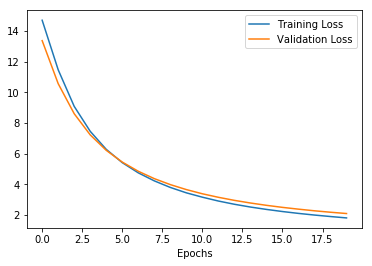

In [25]:
# Finally we plot the graphs for loss vs epochs.
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')

Lets see how the network predictions compare with the actual ratings.

In [26]:
x, y = test_dataset.__getitem__(4)
pred = net(x)
print("Predicted Ratings: ", pred[y!=0].detach().numpy())
print("Actual Ratings: ", y[y!=0].numpy())

Predicted Ratings:  [3.7169704 1.9690993 3.3711023 3.9272387 3.2386248]
Actual Ratings:  [3.5 3.5 4.  4.  4. ]


## Task 5: Improving the model (10 marks)

From here onwards the assignment becomes open-ended. We have so far implemented a very basic autoencoder for this task. We obtained MSE in the range 2-2.2 on the test data which is still a very huge error and not acceptable in practice. However, there are many changes that we can make in our architecture and learning algorithm to improve its performance. For example:

1. Deeper architecture, different activation functions and different hidden sizes particularly for the middle layer
2. Using Dropout or L2 regularization to reduce overfitting
3. Using Batch norm to improve training
4. Different optimizers like AdaDelta, RMSProp, Adam etc etc
5. Tuning hyperparameters like learning rate, l2 regularization constant, dropout rate etc
6. Using a different loss function like mean absolute error.
7. Creating model ensemble i.e. training multiple neural nets and then combining the outputs of all the networks to get the final output
8. Different algorithm all together like Variational Autoencoders, SVD etc
9. Train for more number of epochs, here we only trained for 20 epochs maybe more epochs can help
10. Early Stopping, learning rate decay

After you have made the changes use your final model to get predictions on all the users using the training data. We have provided you with a file `test_hidden.dat` which contains data in the form `userId, restaurantID`. The user ratings for these restaurantIDs are missing in the training set. From our model predictions we will obtain the ratings corresponding to these restaurants and store them in file `predictions.csv` in the format `prediction` for corresponding `userId, restaurantID` in a predefined sequence. You are then required to upload this CSV file on the kaggle competition created for this assignment along with this notebook.

Below we have given a function that you can run after training your final model to generate the `predictions.csv` file. You might need to change the function a little according to the way you take predictions from your model. This function assumes that you have a pytorch model instance *net* as your final model.

In [ ]:
def get_predictions(net, train_data = train_smat):
    
    def get_test_smat(filename = 'data/test_hidden.dat'):
        sparse_dict = defaultdict(list)
        for line in open(filename):
            splitted_line = line.split(',')
            sparse_dict[int(splitted_line[0])].append((int(splitted_line[1])))

        sparse_mat = []
        sKeys = sorted(sparse_dict)
        for key in sKeys:
            sparse_mat.append(sparse_dict[key])
        
        return sparse_mat
            
            
    test_smat = get_test_smat()
    preds = []
    for i in range(len(train_data)):
        
        #Getting the actual vector from the sparse representation
        x = torch.zeros(5138)
        for j in range(len(train_data[i])):
            x[train_data[i][j][0]] = train_data[i][j][1]
        with torch.set_grad_enabled(False):
            pred = net(x).detach().numpy() ## This logic might be different for your model, change this accordingly
        
        pred = pred[test_smat[i]]
        user_rest_pred = np.concatenate([i*np.ones((len(pred),1),dtype=np.int),np.array(test_smat[i],dtype=np.int)[:,None], np.array(pred)[:,None]],axis = 1)
        preds += user_rest_pred.tolist()
        
    preds = np.array(preds)
    df = pd.DataFrame(preds)
    df[0] = df[0].astype('int')
    df[1] = df[1].astype('int')
    df[2] = df[2].astype('float16')
    df = df.drop(df.columns[[0, 1]], axis=1)
    df['index1'] = df.index.values
    df.columns = ['rating', 'id']
    df = df[['id','rating']]
    df.to_csv('predictions.csv', index=False, header=True)    
    return df

In [ ]:
df = get_predictions(net)
df.head()

The `predictions.csv` needs to be uploaded on the Kaggle, instructions for which will be communicated through mail.